In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import easygems.healpix as egh
import osmnx as ox
from shapely.geometry import mapping
from cartopy.feature import ShapelyFeature
import intake
from easygems import healpix as egh
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors



cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")["online"]
ds = cat["um_glm_n2560_RAL3p3"](zoom = 10).to_dask()
ds = ds.pipe(egh.attach_coords)

/opt/anaconda3/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [2]:
ds

<xarray.Dataset> Size: 13TB
Dimensions:  (time: 10489, cell: 12582912)
Coordinates:
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
    crs      int64 8B 0
  * cell     (cell) int64 101MB 0 1 2 3 ... 12582908 12582909 12582910 12582911
    lat      (cell) float64 101MB 0.0373 0.0746 0.0746 ... -0.0746 -0.0373
    lon      (cell) float64 101MB 45.0 45.04 44.96 45.0 ... 315.0 315.0 315.0
Data variables: (12/26)
    clivi    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clt      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clwvi    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    hflsd    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    hfssd    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    huss     (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    ...       ...
    rsutcs   (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    sftlf    (cell) float64 101MB dask.array<chunksize=(98304,), meta=np.ndarray>
    tas      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    ts       (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    uas      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    vas      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>

In [6]:

# Define the prefectures included in Greater Tokyo
prefectures = ["Tokyo, Japan", "Kanagawa, Japan", "Saitama, Japan", "Chiba, Japan"]

# Download and merge their geometries
gdfs = [ox.geocode_to_gdf(name) for name in prefectures]
greater_tokyo_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
greater_tokyo_gdf = greater_tokyo_gdf.dissolve()  # Merge into single polygon

# Extract the unified geometry
tokyo_geometry = greater_tokyo_gdf.geometry.iloc[0]


# Create land mask: only retain points where orography is valid
land_mask = ds['orog'] > 0  # or use `.notnull()` if orog has NaNs over ocean
ts_land = ds['ts'].isel(time=1).where(land_mask)

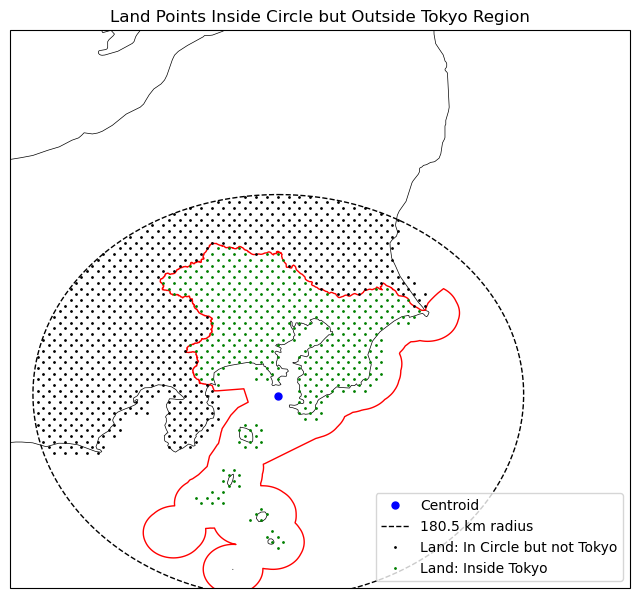

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.feature import ShapelyFeature
from shapely.geometry import Point, Polygon, MultiPolygon
import geopandas as gpd
from geopy.distance import geodesic

# --- Step 1: Find largest polygon from tokyo_geometry and compute centroid ---
if isinstance(tokyo_geometry, MultiPolygon):
    largest_poly = max(tokyo_geometry.geoms, key=lambda p: p.area)
else:
    largest_poly = tokyo_geometry

tokyo_centroid = largest_poly.centroid

# Compute max radius from centroid to boundary
boundary_coords = np.array(largest_poly.exterior.coords)
distances_m = [
    geodesic((tokyo_centroid.y, tokyo_centroid.x), (lat, lon)).meters
    for lon, lat in boundary_coords  # coords = (lon, lat)
]
radius_m = max(distances_m)
radius_km = radius_m / 1000
center_lat, center_lon = tokyo_centroid.y, tokyo_centroid.x

# --- Step 2: Create circle around centroid ---
def create_circle(lat, lon, radius_km, num_points=360):
    angles = np.linspace(0, 360, num_points)
    circle_lats, circle_lons = [], []
    for angle in angles:
        dest = geodesic(kilometers=radius_km).destination((lat, lon), angle)
        circle_lats.append(dest.latitude)
        circle_lons.append(dest.longitude)
    return circle_lons, circle_lats

circle_lons, circle_lats = create_circle(center_lat, center_lon, radius_km)
circle_polygon = Polygon(zip(circle_lons, circle_lats))  # For masking

# --- Step 3: Prepare valid land points ---
ts_2d = ts_land.values
valid_mask = ~np.isnan(ts_2d)

# Use 2D coordinates directly from xarray (broadcasted)
lat_2d, lon_2d = xr.broadcast(ds['lat'], ds['lon'])  # ensures shapes match ts_land

# Apply the same valid mask
valid_lons = lon_2d.values[valid_mask]
valid_lats = lat_2d.values[valid_mask]

# Create shapely Point series
points = gpd.GeoSeries([Point(lon, lat) for lon, lat in zip(valid_lons, valid_lats)], crs="EPSG:4326")

# --- Step 4: Identify those in circle but not in Tokyo ---
inside_circle = points.within(circle_polygon)
outside_tokyo = ~points.within(largest_poly)
highlight_mask = inside_circle & outside_tokyo
highlight_points = points[highlight_mask]



# --- Step 6: Highlight points inside Tokyo ---
inside_tokyo = points.within(largest_poly)
highlight_inside_tokyo = points[inside_tokyo]



# --- Step 5: Plot everything ---
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([137.5, 142.5, 33.5, 38.0], crs=ccrs.PlateCarree())
ax.set_facecolor('white')

# Map features
ax.add_feature(cf.COASTLINE, linewidth=0.5)
ax.add_feature(cf.BORDERS, linewidth=0.3)

# Tokyo boundary
tokyo_boundary = ShapelyFeature([tokyo_geometry], ccrs.PlateCarree(),
                                 edgecolor='red', facecolor='none', linewidth=1)
ax.add_feature(tokyo_boundary)

# Centroid + circle
ax.plot(tokyo_centroid.x, tokyo_centroid.y, 'bo', markersize=5,
        transform=ccrs.PlateCarree(), label='Centroid')
ax.plot(circle_lons, circle_lats, 'k--', linewidth=1.0, label=f'{radius_km:.1f} km radius')

# Highlighted points outside Tokyo but inside circle
ax.plot(highlight_points.x, highlight_points.y, 'k.', markersize=2, label='Land: In Circle but not Tokyo')

# Highlighted points inside Tokyo
ax.plot(highlight_inside_tokyo.x, highlight_inside_tokyo.y, 'g.', markersize=2, label='Land: Inside Tokyo')



# Legend and title
ax.legend(loc='lower right')
plt.title("Land Points Inside Circle but Outside Tokyo Region")
plt.show()


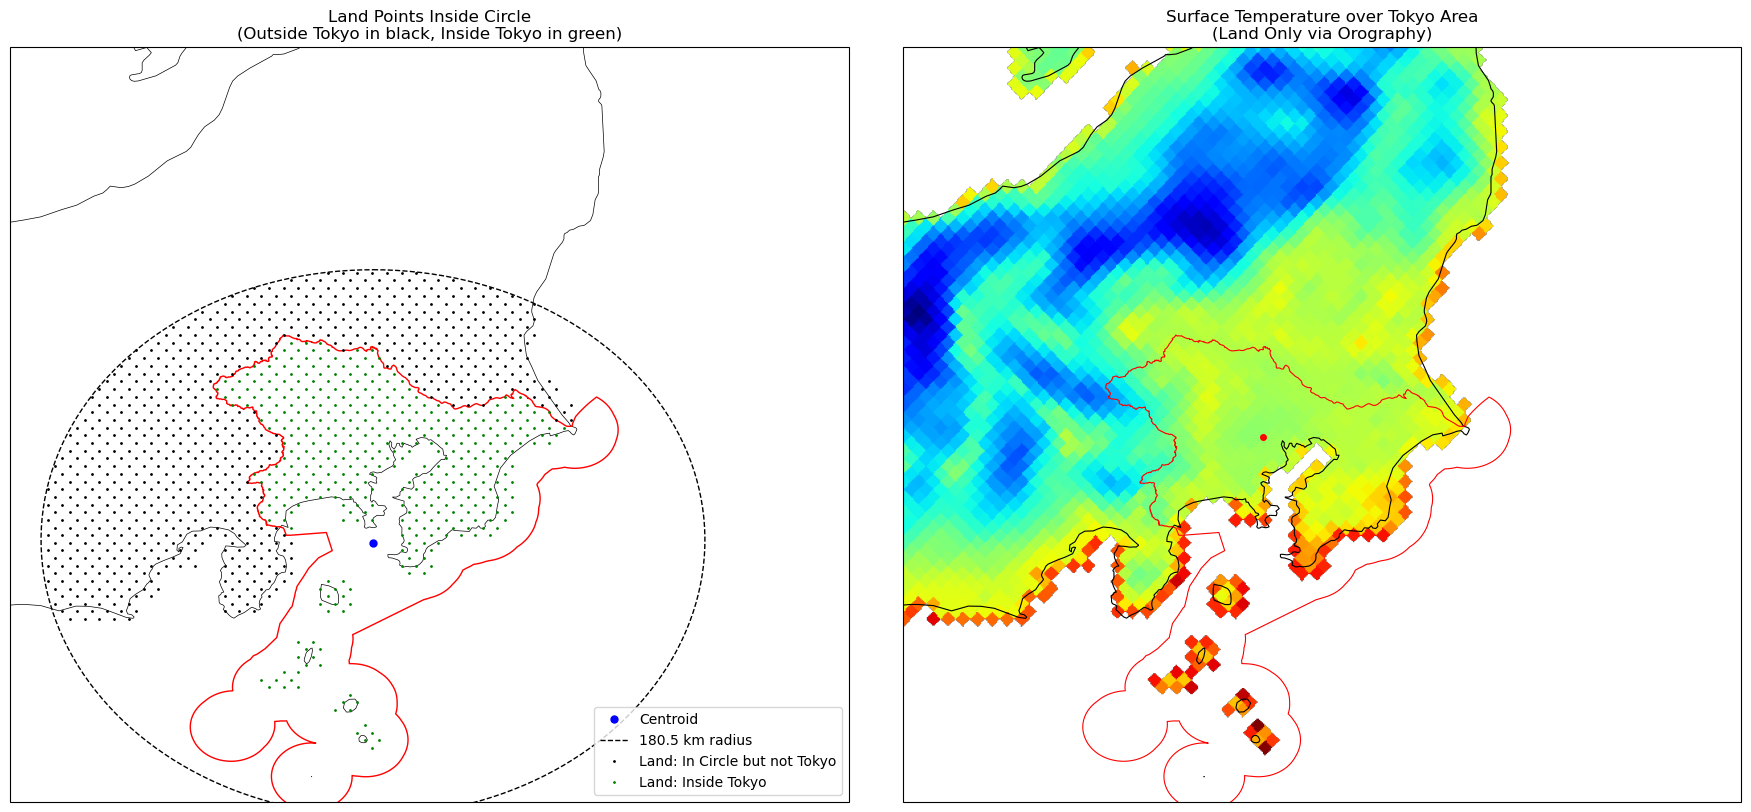

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.feature import ShapelyFeature
from shapely.geometry import Point, Polygon, MultiPolygon
import geopandas as gpd
from geopy.distance import geodesic
import xarray as xr
import pandas as pd
import osmnx as ox

# --- Step 0: Load and merge Greater Tokyo geometry ---
prefectures = ["Tokyo, Japan", "Kanagawa, Japan", "Saitama, Japan", "Chiba, Japan"]
gdfs = [ox.geocode_to_gdf(name) for name in prefectures]
greater_tokyo_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
greater_tokyo_gdf = greater_tokyo_gdf.dissolve()
tokyo_geometry = greater_tokyo_gdf.geometry.iloc[0]

# --- Step 1: Largest polygon + centroid ---
if isinstance(tokyo_geometry, MultiPolygon):
    largest_poly = max(tokyo_geometry.geoms, key=lambda p: p.area)
else:
    largest_poly = tokyo_geometry
tokyo_centroid = largest_poly.centroid

# Compute max radius from centroid to boundary
boundary_coords = np.array(largest_poly.exterior.coords)
distances_m = [
    geodesic((tokyo_centroid.y, tokyo_centroid.x), (lat, lon)).meters
    for lon, lat in boundary_coords
]
radius_km = max(distances_m) / 1000
center_lat, center_lon = tokyo_centroid.y, tokyo_centroid.x

# --- Step 2: Create circle polygon ---
def create_circle(lat, lon, radius_km, num_points=360):
    angles = np.linspace(0, 360, num_points)
    circle_lats, circle_lons = [], []
    for angle in angles:
        dest = geodesic(kilometers=radius_km).destination((lat, lon), angle)
        circle_lats.append(dest.latitude)
        circle_lons.append(dest.longitude)
    return circle_lons, circle_lats

circle_lons, circle_lats = create_circle(center_lat, center_lon, radius_km)
circle_polygon = Polygon(zip(circle_lons, circle_lats))

# --- Step 3: Prepare valid land points ---
land_mask = ds['orog'] > 0
ts_land = ds['ts'].isel(time=1).where(land_mask)
ts_2d = ts_land.values
valid_mask = ~np.isnan(ts_2d)

lat_2d, lon_2d = xr.broadcast(ds['lat'], ds['lon'])
valid_lons = lon_2d.values[valid_mask]
valid_lats = lat_2d.values[valid_mask]

points = gpd.GeoSeries([Point(lon, lat) for lon, lat in zip(valid_lons, valid_lats)], crs="EPSG:4326")

# --- Step 4: Points inside circle, inside/outside Tokyo ---
inside_circle = points.within(circle_polygon)
outside_tokyo = ~points.within(largest_poly)
inside_tokyo = points.within(largest_poly)

highlight_outside_tokyo = points[inside_circle & outside_tokyo]
highlight_inside_tokyo = points[inside_circle & inside_tokyo]

# --- Step 5: Plot both maps side-by-side ---
fig, ax = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# --- Plot 1: Highlighted Land Points ---
ax[0].set_extent([137.5, 142.5, 33.5, 38.0], crs=ccrs.PlateCarree())
ax[0].add_feature(cf.COASTLINE, linewidth=0.5)
ax[0].add_feature(cf.BORDERS, linewidth=0.3)
tokyo_boundary = ShapelyFeature([tokyo_geometry], ccrs.PlateCarree(),
                                 edgecolor='red', facecolor='none', linewidth=1)
ax[0].add_feature(tokyo_boundary)

ax[0].plot(tokyo_centroid.x, tokyo_centroid.y, 'bo', markersize=5,
           transform=ccrs.PlateCarree(), label='Centroid')
ax[0].plot(circle_lons, circle_lats, 'k--', linewidth=1.0, label=f'{radius_km:.1f} km radius')

ax[0].plot(highlight_outside_tokyo.x, highlight_outside_tokyo.y, 'k.', markersize=2,
           label='Land: In Circle but not Tokyo')
ax[0].plot(highlight_inside_tokyo.x, highlight_inside_tokyo.y, 'g.', markersize=2,
           label='Land: Inside Tokyo')

ax[0].legend(loc='lower right')
ax[0].set_title("Land Points Inside Circle\n(Outside Tokyo in black, Inside Tokyo in green)")

# --- Plot 2: Land Surface Temperature ---
ax[1].set_extent([137.5, 142.5, 33.5, 38.0], crs=ccrs.PlateCarree())
ax[1].add_feature(cf.COASTLINE, linewidth=0.8)
ax[1].add_feature(cf.BORDERS, linewidth=0.4)
tokyo_boundary2 = ShapelyFeature([tokyo_geometry], ccrs.PlateCarree(),
                                  edgecolor='red', facecolor='none', linestyle='-', linewidth=0.8)
ax[1].add_feature(tokyo_boundary2)

# Plot ts_land using egh.healpix_show
egh.healpix_show(ts_land, ax=ax[1], cmap='jet')

# Mark Tokyo
ax[1].plot(139.6500, 35.6764, 'ro', markersize=4, transform=ccrs.PlateCarree())

ax[1].set_title("Surface Temperature over Tokyo Area\n(Land Only via Orography)")

plt.tight_layout()
plt.show()


In [11]:
ts_2d

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

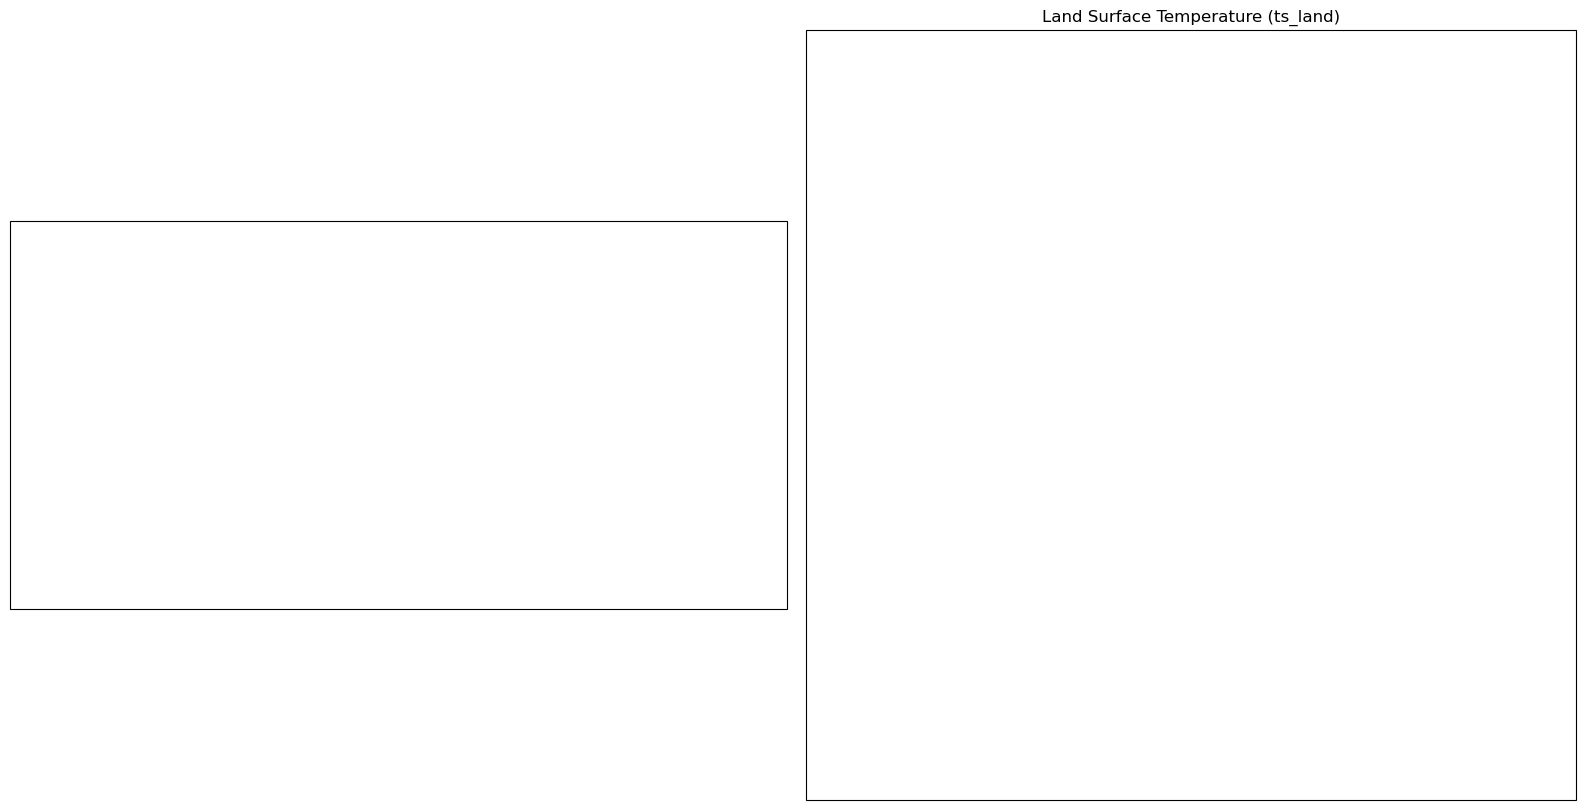